In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
%matplotlib inline

## LOAD RESOURCES ##

In [112]:
path = 'resources/food-inspections-cleaned.parquet'
df = pq.read_table(path).to_pandas()
df.head(2)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct
0,2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822,Restaurant,High,4634-4636 N KEDZIE AVE,60625,2019-10-25,Complaint,Pass,None,41.965719,-87.708538,True,ALBANY PARK,"NORTH PARK,ALBANY PARK",33,27
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968820,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38


In [113]:
nb_NaN_violations = len(df) - df['Violations'].count()
print("We have {} out of {} inspections with no violations recorded. It makes {}%.".format(nb_NaN_violations, len(df), "%.2f" % (nb_NaN_violations/len(df)*100)))

We have 51070 out of 191827 inspections with no violations recorded. It makes 26.62%.


## EXPLODE VIOLATIONS ##

In [114]:
df_split = df.copy()
df_split['Violations'] = df_split['Violations'].map(lambda x: str(x).split('|'))
df_split.head(3)

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violations,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct
0,2320519,SALAM RESTAURANT,SALAM RESTAURANT,2002822,Restaurant,High,4634-4636 N KEDZIE AVE,60625,2019-10-25,Complaint,Pass,[None],41.965719,-87.708538,True,ALBANY PARK,"NORTH PARK,ALBANY PARK",33,27
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"[3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL ...",41.968820,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38
2,2320412,"DANTE'S PIZZA,INC.",DANTE'S PIZZA,2092884,Restaurant,High,3028 W ARMITAGE AVE,60647,2019-10-24,Canvass,Fail,"[38. INSECTS, RODENTS, & ANIMALS NOT PRESENT -...",41.917539,-87.703728,False,LOGAN SQUARE,LOGAN SQUARE,32,22


In [115]:
violations = df_split.explode('Violations').rename(columns={'Violations' : 'Violation'})
violations = violations[violations['Violation'] != 'None']
nb_violations = len(violations)
violations.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violation,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND ...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERC...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,50. HOT & COLD WATER AVAILABLE; ADEQUATE PRES...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, ...",41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38


## GET VIOLATIONS IDS ##

In [116]:
def get_violation_id(x):
    return x.split('.')[0].strip()

violations['Violation ID'] = violations['Violation'].apply(get_violation_id).astype(int)
violations.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,Results,Violation,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation ID
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,3
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,5. PROCEDURES FOR RESPONDING TO VOMITING AND ...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,5
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERC...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,25
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,50. HOT & COLD WATER AVAILABLE; ADEQUATE PRES...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,50
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,Fail,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, ...",41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,53


## GET VIOLATIONS SEVERITY ##

In [117]:
def is_violation_high_severity(x):
    return x <= 14

def is_violation_medium_severity(x):
    return 15 <= x and x <= 29

def is_violation_low_severity(x):
    return 30 <= x

def get_violation_severity(x):
    if is_violation_high_severity(x):
        return 'High'
    if is_violation_medium_severity(x):
        return 'Medium'
    return 'Low'

violations['Violation Severity'] = violations['Violation ID'].apply(get_violation_severity)
violations.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,Zip,Inspection Date,Inspection Type,...,Violation,Latitude,Longitude,Re-inspection,Community,Neighborhood,Ward,Precinct,Violation ID,Violation Severity
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,3,High
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,5. PROCEDURES FOR RESPONDING TO VOMITING AND ...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,5,High
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERC...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,25,Medium
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,50. HOT & COLD WATER AVAILABLE; ADEQUATE PRES...,41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,50,Low
1,2320509,TAQUERIA EL DORADO,TAQUERIA EL DORADO,2694960,Restaurant,High,2114 W LAWRENCE AVE,60625,2019-10-25,License,...,"53. TOILET FACILITIES: PROPERLY CONSTRUCTED, ...",41.96882,-87.682292,True,LINCOLN SQUARE,LINCOLN SQUARE,47,38,53,Low


## SAVE THE VIOLATIONS ORIENTED DATASET ##

In [118]:
violations.to_pickle('resources/violations_oriented.pickle')

## WHICH VIOLATIONS ARE THE MOST COMMON ? ##

In [119]:
all_violations_ids = violations['Violation ID'].unique()
all_violations_ids.sort()
all_violations_ids

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 70])

In [120]:
violations_id_count = violations[['Inspection ID', 'Violation ID']].groupby('Violation ID').count().rename(columns={'Inspection ID' : 'Count'})
violations_id_count.sort_values('Count', ascending=False).head(10)

,Count
Violation ID,
34,70545
35,63982
33,62443
38,57007
32,54139
41,34645
36,27642
3,18641
18,16844


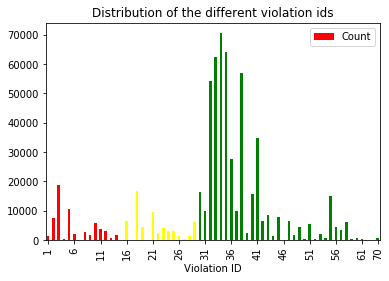

In [122]:
colors = [['red']*14 + ['yellow']*15 + ['green']*(len(violations_id_count) - 14 - 15)]
violations_id_count.plot.bar(color=colors)
plt.title("Distribution of the different violation ids")
xticks = plt.gca().xaxis.get_major_ticks()
for i in range(len(xticks)):
    if i % 5 != 0:
        xticks[i].set_visible(False)
xticks[-1].set_visible(True)

## ARE THE VIOLATIONS MOSTLY SEVERE ? ##

In [123]:
violations_severity_count = violations[['Inspection ID', 'Violation Severity']].groupby('Violation Severity').count().rename(columns={'Inspection ID' : 'Count'})
violations_severity_count['Percent'] = violations_severity_count['Count'].apply(lambda x: "%.3f" % (x/nb_violations*100))
violations_severity_count

,Count,Percent
Violation Severity,,
High,59917,9.657
Low,500952,80.740
Medium,59585,9.603


Text(0.5, 1.0, 'Distribution of the severity levels for the violations')

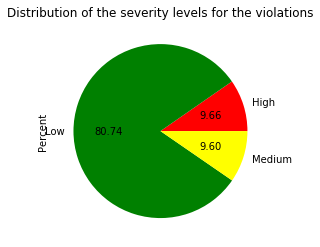

In [130]:
violations_severity_count['Percent'].astype(float).plot.pie(autopct='%.2f', colors=['red', 'green', 'yellow'], fontsize=10)
plt.title("Distribution of the severity levels for the violations")

In [131]:
df_violation_ids = df_split.copy()
df_violation_ids['Violation IDs'] = df_violation_ids['Violations'].apply(lambda violations: [get_violation_id(x) for x in violations])
df_violation_ids['Nb Violations'] = df_violation_ids['Violation IDs'].apply(lambda x: 0 if 'nan' in x else len(x))
df_violation_ids[['Violations', 'Violation IDs', 'Nb Violations']].head()

,Violations,Violation IDs,Nb Violations
0,[None],[None],1
1,"[3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL ...","[3, 5, 25, 50, 53, 53, 56, 58]",8
2,"[38. INSECTS, RODENTS, & ANIMALS NOT PRESENT -...","[38, 47, 53, 55, 58, 60]",6
3,"[3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL ...","[3, 48, 51, 55, 58]",5
4,[14. REQUIRED RECORDS AVAILABLE: SHELLSTOCK TA...,"[14, 25, 41, 47, 48, 55, 56, 57, 58, 60]",10


Text(0.5, 1.0, 'Distribution of the number of violations by inspection')

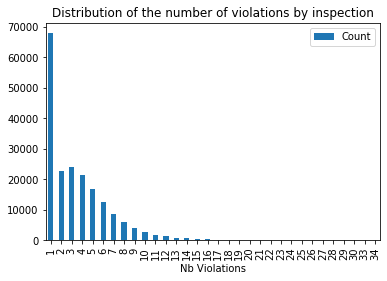

In [132]:
df_violation_ids[['Inspection ID', 'Nb Violations']].groupby('Nb Violations').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar()
plt.title("Distribution of the number of violations by inspection")

In [134]:
df_violation_ids['Nb Violations of high severity'] = df_violation_ids['Violation IDs'].apply(lambda violation_ids: len([x for x in violation_ids if x != 'None' and is_violation_high_severity(int(x))]))
df_violation_ids['Nb Violations of medium severity'] = df_violation_ids['Violation IDs'].apply(lambda violation_ids: len([x for x in violation_ids if x != 'None' and is_violation_medium_severity(int(x))]))
df_violation_ids['Nb Violations of low severity'] = df_violation_ids['Violation IDs'].apply(lambda violation_ids: len([x for x in violation_ids if x != 'None' and is_violation_low_severity(int(x))]))
df_violation_ids[['Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
0,1,0,0,0
1,8,2,1,5
2,6,0,0,6
3,5,1,0,4
4,10,1,1,8


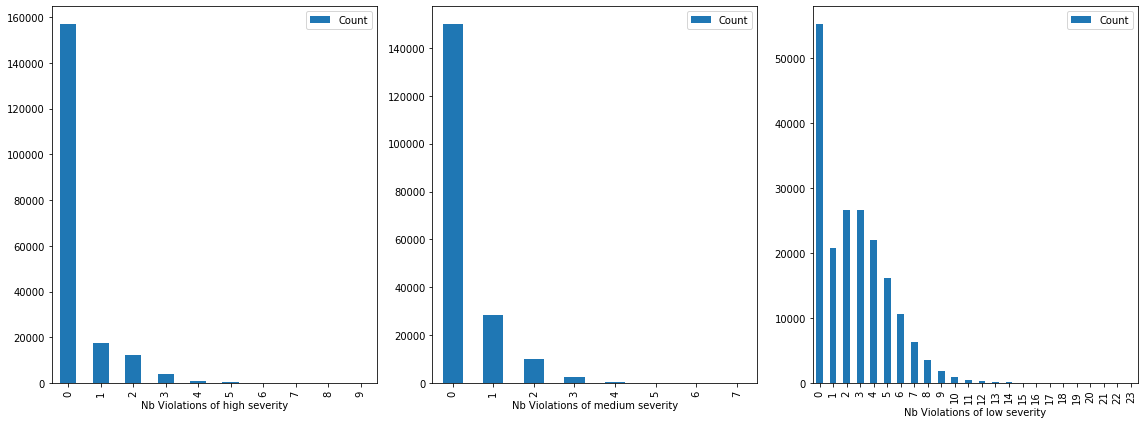

In [136]:
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
df_violation_ids[['Inspection ID', 'Nb Violations of high severity']].groupby('Nb Violations of high severity').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar(ax=ax1)
df_violation_ids[['Inspection ID', 'Nb Violations of medium severity']].groupby('Nb Violations of medium severity').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar(ax=ax2)
df_violation_ids[['Inspection ID', 'Nb Violations of low severity']].groupby('Nb Violations of low severity').count().rename(columns={'Inspection ID' : 'Count'}).plot.bar(ax=ax3)
plt.tight_layout()

## SAVE THE DATASET EXPANDED WITH MORE INFO ABOUT VIOLATIONS ##

In [137]:
df_violation_ids.to_pickle('resources/dataset_with_violations.pickle')

## HOW VARY THE NUMBER OF VIOLATIONS THROUGH TIME ? ##

In [138]:
nb_violations_by_date = df_violation_ids[['Inspection Date', 'Nb Violations', 'Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].groupby('Inspection Date').sum()
nb_violations_by_date.head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection Date,,,,
2010-01-04,21,0,3,13
2010-01-05,260,5,21,215
2010-01-06,289,13,38,215
2010-01-07,184,5,9,156
2010-01-08,138,4,8,109


Text(0.5, 1.0, 'The variation of the number of violations through dates')

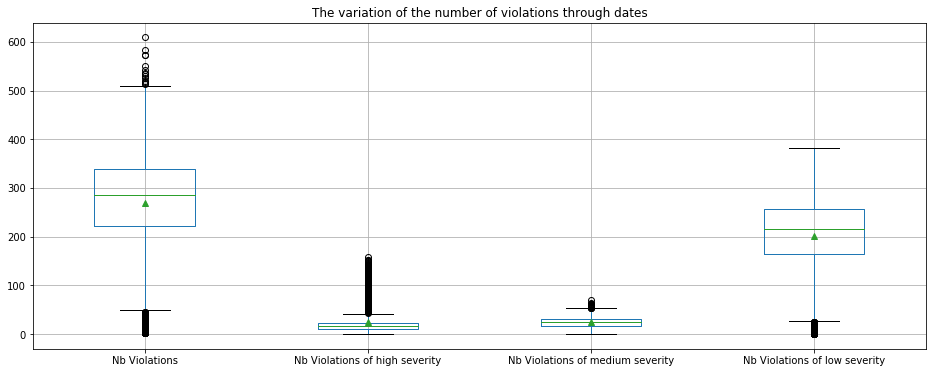

In [139]:
nb_violations_by_date.plot.box(grid=True, showmeans=True, figsize=(16,6))
plt.title("The variation of the number of violations through dates")

In [140]:
nb_violations_by_year = nb_violations_by_date.copy().reset_index()
nb_violations_by_year['Inspection Date'] = nb_violations_by_year['Inspection Date'].apply(lambda x: x.year)
nb_violations_by_year.rename(columns={'Inspection Date' : 'Inspection Year'}, inplace=True)
nb_violations_by_year = nb_violations_by_year.groupby('Inspection Year').sum()
nb_violations_by_year.head()

,Nb Violations,Nb Violations of high severity,Nb Violations of medium severity,Nb Violations of low severity
Inspection Year,,,,
2010,59399,3344,4605,45901
2011,64714,3303,5196,51018
2012,61874,3305,5252,47855
2013,64270,3126,5411,49629
2014,71459,3924,5833,56564


Text(0.5, 1.0, 'Number of violations by year')

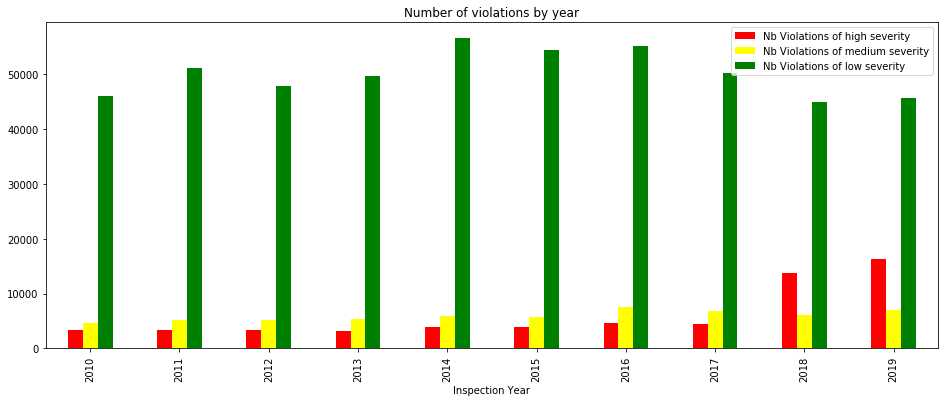

In [141]:
nb_violations_by_year[['Nb Violations of high severity', 'Nb Violations of medium severity', 'Nb Violations of low severity']].plot.bar(color=['red', 'yellow', 'green'], figsize=(16,6))
plt.title("Number of violations by year")